# Chapter 3: Long/Short Methodologies: Absolute and Relative

This chapter introduces the relative series methodology

1. Build a dataframe of S&P 500 constituents
2. Download historical prices with yfinance library
3. Bullish/Bearish regime in absolute/relative series
4. Relative  & Utilities Function
5. Softbank in absolute JPY & relative to Nasdaq 100 in USD
6. GEMS Stocks relative to S&P 500
7. Sector Average
8. Cyclicals v. defensives
9. Cross-market comparison
10. Disney MCU rise and fall

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
import datetime 
from dateutil.relativedelta import relativedelta

### 1. Build a dataframe of S&P 500 constituents

1. Pandas read_html is an efficient way to convert tables from the internet into dataframe. 
2. Webpages often contain multiple tables, so make sure you index the correct table. Here we reference the first table on the page [0]
3. Next, we rename columns. Different webpages have different names for the same fields: symbol v. ticker, GICS sector v. sector etc. We make a habit of harmonising names to facilitate processing
4. We will be downloading historical prices from Yahoo. So, we need to convert tickers into a format compatible with the yfinance library: .str.replace('.', '-', regex =False)
5. We sort tickers by sector and ticker in ascending order
Tip: Tables and webpages get updated regularly so make sure to check the shape of the df.

In [2]:
df_SP500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
df_SP500 = df_SP500.rename(columns={'Symbol':'ticker', 'Security': 'name', 'GICS Sector':'sector','GICS Sub-Industry':'sub-industry'})
df_SP500['ticker'] = df_SP500['ticker'].str.replace('.', '-', regex =False)
df_SP500 = df_SP500.sort_values(by = ['sector','name']).set_index('ticker')

bm_ticker = '^GSPC'
tickers_list = [bm_ticker] + list(df_SP500.index)[:]
df_SP500.groupby('sector').count()

,name,sub-industry,Headquarters Location,Date added,CIK,Founded
sector,,,,,,
Communication Services,23,23,23,23,23,23
Consumer Discretionary,51,51,51,51,51,51
Consumer Staples,38,38,38,38,38,38
Energy,23,23,23,23,23,23
Financials,73,73,73,73,73,73
Health Care,60,60,60,60,60,60
Industrials,78,78,78,78,78,78
Information Technology,69,69,69,69,69,69
Materials,26,26,26,26,26,26


### 2. Download historical prices with yfinance library

1.	batch download "Close" prices from yfinance
    1.	tickers_list: make sure all tickers are compatible with the yfinance library 
    2.	batch_size: data is processed in batches. Single download sometimes generate errors
    3.	start, end: self-explanatory
    4.	show_batch = True, shows tickers as they are downloaded
    5.	Loop to download ['Close'] prices in batches
    6.	Populate the px_df by joining each batch and return px_df 


In [3]:
def batch_px_df(tickers_list,batch_size, start, end,show_batch = False):
    px_df = pd.DataFrame()
    loop_size = int(len(tickers_list) // batch_size) + 2
    for t in range(1,loop_size): # Batch download
        try:
            m = (t - 1) * batch_size
            n = t * batch_size
            batch_list = tickers_list[m:n]
            if show_batch:
                print(batch_list,m,n)
            batch_download = yf.download(tickers= batch_list,start= start, end = end, interval = "1d",
                                group_by = 'column',auto_adjust = True, prepost = True)['Close']
            px_df = px_df.join(batch_download, how='outer')
        except:
            pass
    return px_df

1. Generate df_abs
2. Generate df_rel of relative prices by dividing the df_abs by the benchmark ticker and rebase to the first benchmark value 
3. Print the shape of the absolute and relative df

In [4]:
batch_size = 51 ; start= '2001-01-01' ; end = None

df_abs = batch_px_df(tickers_list,batch_size, start, end,show_batch = False).round(0)
df_rel = df_abs.dropna(subset=[bm_ticker], axis=0)
df_rel = round(df_abs.divide(df_abs[bm_ticker], axis=0).mul(df_abs[df_abs[bm_ticker].notna()].iloc[0,list(df_abs.columns).index(bm_ticker)]),2)
df_abs.shape, df_rel.shape  

[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  45 of 45 completed


((6132, 504), (6132, 504))

### 3. Bullish/Bearish regime in absolute/relative series using 1 year breakout/breakdown

We use a classic one-year high/low as a proxy for the bullish/bearish regime. Stocks that have printed a 252 one-year high are deemed bullish and expected to remain strong. Conversely, stocks that have printed a one-year low are expected to exhibit continued weakness. 

1. Instantiate a bullbear df. Copying the benchmark price and calculate cumulative returns
2. generate 2 dataframes from absolute and relative price series:
    1. np.where price hits a 252 day high, assign 1 for bullish
    2. np.where price hits a 252 day low, assign -1 for bearish
    3. else assign NaN
    4. forward fillna to propagate bullish or bearish regime
3. Horizontal count of stocks in bullish or bearish territory. Calculate average lateral bullishness/bearishness for both absolute and relative series
4. Plot benchmark and lateral counts for the absolute, reative abs & rel, average absolute and relative

Absolute series are highly correlated to the benchmark. It is not uncommon to have close to 100% of the consituents be in either bullish or bearish territory. However, with relative series, roughly 40% to 60% of the constituents will be in either bullish or bearish territory at any point in time. This means there are more issues to shop from and bild a portfolio


In [5]:
window = 252 # 1 year rolling window
bullbear = pd.DataFrame()
bullbear['benchmark'] = df_abs[bm_ticker].copy()
bullbear['bm_returns'] = np.exp(np.log(bullbear/bullbear.shift()).cumsum()) - 1

bo_abs = pd.DataFrame(data= np.where(df_abs >= df_abs.rolling(window).max(),1,
                                     np.where(df_abs<=df_abs.rolling(window).min(),-1,np.nan)), 
                      index= df_abs.index,columns= df_abs.columns).ffill()
bo_abs = bo_abs.dropna(how = 'all', axis=0)

bo_rel = pd.DataFrame(data = np.where(df_rel >= df_rel.rolling(window).max(),1,
                                np.where(df_rel <= df_rel.rolling(window).min(),-1,np.nan)), 
                      index= df_rel.index,columns= df_rel.columns).ffill()
bo_rel = bo_rel.dropna(how = 'all', axis=0)

bo_abs_count = bo_abs.count(axis=1) 
bo_rel_count = bo_rel.count(axis=1) 
bullbear['bulls_absolute'] = bo_abs[bo_abs > 0].count(axis=1).div(bo_abs_count,fill_value=0) * 100
bullbear['bears_absolute'] = bo_abs[bo_abs < 0].count(axis=1).div(bo_abs_count,fill_value=0) * 100 
bullbear['bulls_relative'] = bo_rel[bo_rel > 0].count(axis=1).div(bo_rel_count,fill_value=0) * 100  
bullbear['bears_relative'] = bo_rel[bo_rel < 0].count(axis=1).div(bo_rel_count,fill_value=0) * 100  
bullbear['bullbear_absolute_avg'] = bo_abs.mean(axis=1) 
bullbear['bullbear_relative_avg'] = bo_rel.mean(axis=1) 
bullbear = round(bullbear,2).ffill()

<Axes: title={'center': 'S&P500: 1 year Bullish/Bearish average absolute & relative series'}, xlabel='Date'>

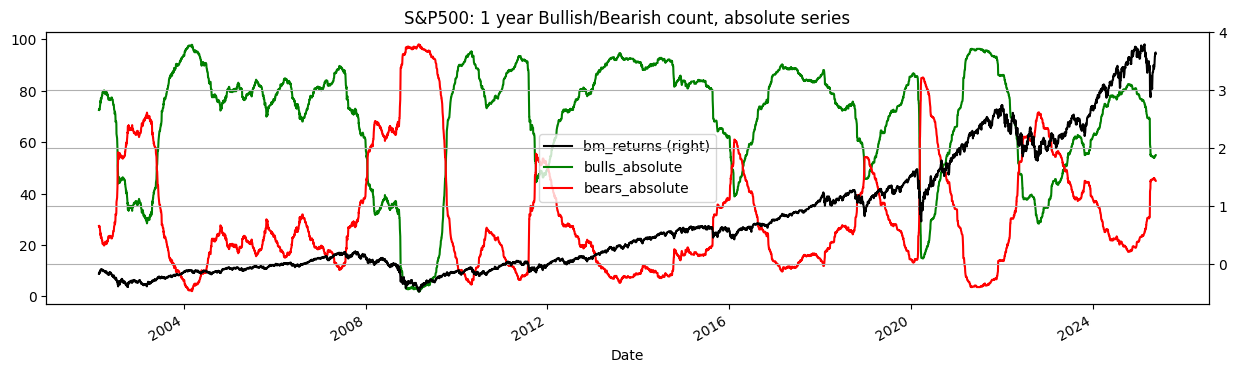

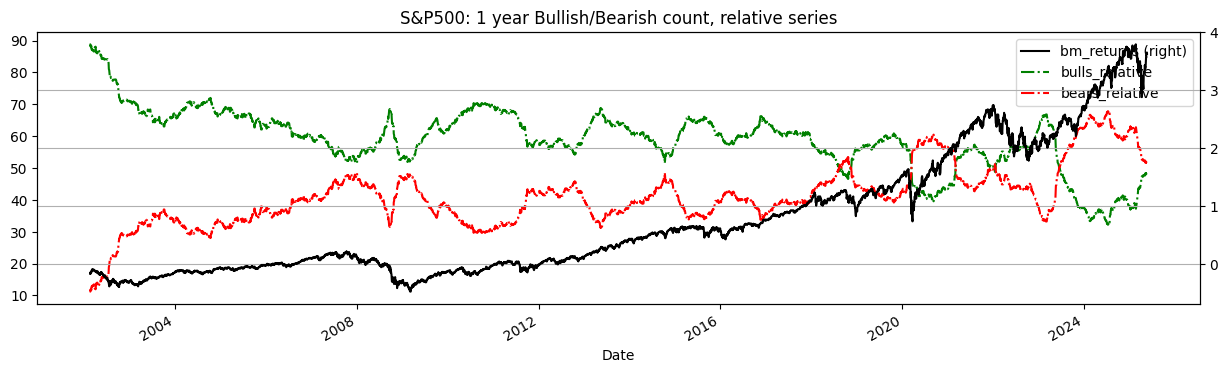

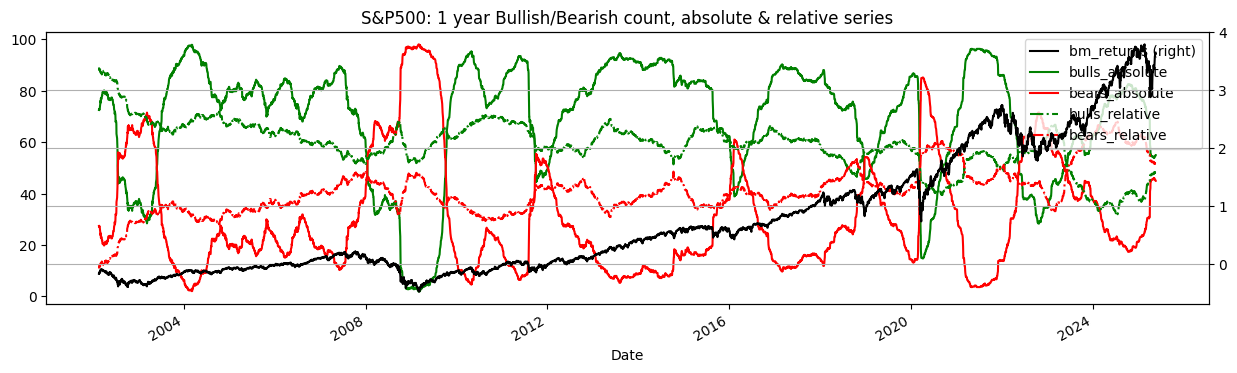

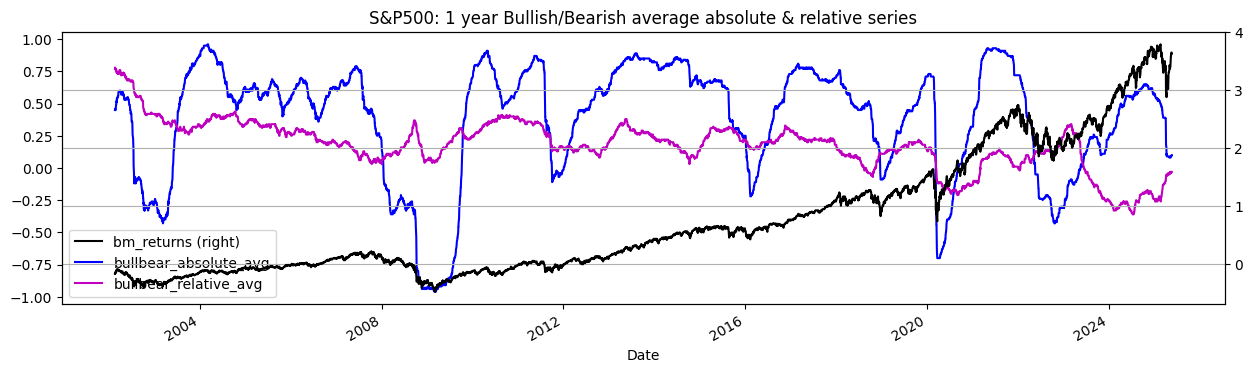

In [6]:
bullbear[280:][['bm_returns','bulls_absolute', 'bears_absolute']].plot(figsize=(15,4),
                style=['k','g', 'r'],grid=True,secondary_y=['bm_returns'],
                title = 'S&P500: 1 year Bullish/Bearish count, absolute series')

bullbear[280:][['bm_returns','bulls_relative', 'bears_relative']].plot(figsize=(15,4),
                style=['k','g-.', 'r-.'],grid=True,secondary_y=['bm_returns'],
                title = 'S&P500: 1 year Bullish/Bearish count, relative series')

bullbear[280:][['bm_returns','bulls_absolute', 'bears_absolute', 'bulls_relative', 'bears_relative']].plot(figsize=(15,4),
                style=['k','g', 'r','g-.', 'r-.'],grid=True,secondary_y=['bm_returns'],
                title = 'S&P500: 1 year Bullish/Bearish count, absolute & relative series')

bullbear[280:][['bm_returns','bullbear_absolute_avg','bullbear_relative_avg']].plot(figsize=(15,4),
                style=['k', 'b', 'm'],grid=True,secondary_y=['bm_returns'],
                title = 'S&P500: 1 year Bullish/Bearish average absolute & relative series')


### 4. Relative  & Utilities Function

1. rel_fx(df,_o,_h,_l,_c,bm_df,bm,ccy_df,ccy,start,end,rebase=True,mult=1):

This function converts absolute local price series into fund currency relative to a benchmark. It is a 3 step-process 
    1. Pull benchmark and currency data from their dataframes called bm_df and ccy_df, respectively
    2. Convert OHLC price to benchmark currency by dividing by the currency rate  
    3. Divide by the benchmark: 
        1. rebase = True. This rebases the multiplier to the beginning of the series. This works best when the start of the series is a fixed date. 
        2. rebase = False. This is better suited for continuous series or moving windows such as rolling 1,2, 3 years    

2. dict_swap(dct): this dictionary comprehension swaps keys and values

3. df_from_dict(batch_size,dct,start,end): this function downloads historical prices from dictionary keys,
 and swaps column names with values

4. rohlc(df,relative = False): this verbose function instantiates _o,_h,_l,_c

5. def yf_droplevel(batch_download,ticker): drops multiindex df into single ticker df

In [7]:
def rel_fx(df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase = True, mult = 1000):
    df[ccy] = ccy_df.loc[start:end,ccy].copy().ffill()
    df[bm] = bm_df.loc[start:end,bm].copy().ffill()
    for i in [_o,_h,_l,_c]:
        df[f'r{i}'] = df[i].div(df[ccy])
        if rebase == True:
            df[f'r{i}'] = df[f'r{i}'].div(df[bm]).mul(df[df[bm].notna()].iloc[0,list(df.columns).index(bm)])
        else:
            df[f'r{i}'] = df[f'r{i}'].div(df[bm]) * mult
    return df

def dict_swap(dct):
    dict_swap = {value:key for key,value in dct.items()}
    return dict_swap

def df_from_dict(batch_size,dct,start,end):
    tickers_list = list(dct.keys())
    df = batch_px_df(tickers_list,batch_size, start, end,show_batch = False)
    df = df.rename(columns = dct)
    df = df.tz_localize(None).ffill()
    return df

def rohlc(df,relative = False):
    if relative==True:
        rel = 'r'
    else:
        rel= ''      
    if 'Open' in df.columns:
       _o,_h,_l,_c = f'{rel}Open',f'{rel}High',f'{rel}Low',f'{rel}Close'      
    elif 'open' in df.columns:
        _o,_h,_l,_c = f'{rel}open',f'{rel}high',f'{rel}low',f'{rel}close'
    else:
        _o=_h=_l=_c= np.nan
    return _o,_h,_l,_c

def yf_droplevel(batch_download,ticker):
    df = batch_download.iloc[:, batch_download.columns.get_level_values(1) == ticker]
    df.columns = df.columns.droplevel(1)
    df = df.dropna()
    return df

### 5. Softbank in absolute JPY & relative to Nasdaq 100 in USD

1. We create dictionaries of benchmarks and currencies. We download historical prices. We add 'absolute' and 'local' with 1 values. The bm_df and ccy_df will be re-purposed later
2. We download historical prices for Softbank, instantiate _o,_h,_l,_c, calculate relative prices and plot both absolute in local currency and relative is USD

[*********************100%***********************]  37 of 37 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Softbank Absolute in JPY vs relative to Nasdaq in USD'}, xlabel='Date'>

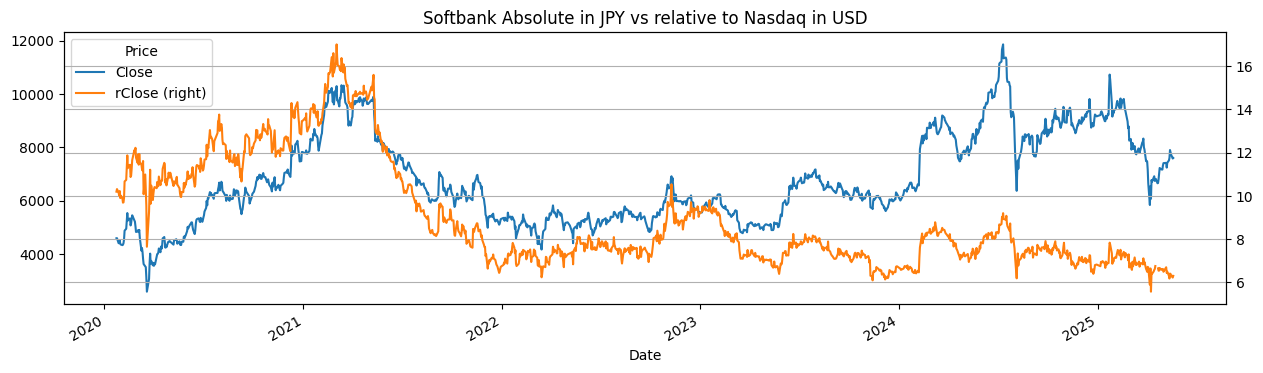

In [8]:
dict_bm = {'^GSPC': 'SP500', '^DJI': 'DOW30', '^IXIC': 'Nasdaq100', '^NYA': 'NYSE ', '^XAX': 'Nyse_Amex', '^RUT': 'Russell2000',
           '^VIX': 'VIX', '^BUK100P': 'CBOEUK100', '^FTSE': 'FTSE100', '^GDAXI': 'DAX', '^FCHI': 'CAC40', '^STOXX50E': 'EuroStocks50', 
           '^N100': 'Euronext100', '^BFX': 'BEL20', 'IMOEX.ME': 'MOEX_Russia', '^N225': 'Nikkei225', '^HSI': 'HangSeng', 
           '000001.SS': 'SSE', '399001.SZ': 'Shenzhen', '^STI': 'STI', '^AXJO': 'ASX200', '^AORD': 'All_Ordinaries', '^BSESN': 'Sensex', 
           '^JKSE': 'Jakarta','^KLSE': 'FTSE_KLCI', '^JKSE': 'Jakarta', '^KLSE': 'FTSE_KLCI', '^NZ50': 'NZX50', '^KS11': 'Kospi', 
           '^TWII': 'TSEC', '^GSPTSE': 'TSX', '^BVSP': 'Bovespa',  '^MXX': 'IPC_Mexico', '^MERV': 'Merval', '^TA125.TA': 'TA125',
           '^IRX': '3M_US_Yield', '^FVX': '5Y_US_Yield', '^TNX': '10Y_US_Yield', '^TYX': '30Y_US_Yield'}
bm_df = df_from_dict(batch_size,dict_bm,start,end)
bm_df['absolute'] = 1

dict_ccy = {'EURUSD=X': 'EURUSD', 'JPY=X': 'USDJPY', 'GBPUSD=X': 'GBPUSD', 'AUDUSD=X': 'AUDUSD', 'NZDUSD=X': 'NZDUSD', 'USDCAD=X': 'USDCAD',
            'EURJPY=X': 'EURJPY', 'GBPJPY=X': 'GBPJPY', 'EURGBP=X': 'EURGBP', 'EURCAD=X': 'EURCAD', 'EURSEK=X': 'EURSEK', 'EURCHF=X': 'EURCHF',
             'EURHUF=X': 'EURHUF','CNY=X': 'USDCNY', 'HKD=X': 'USDHKD','SGD=X': 'USDSGD','INR=X': 'USDINR', 'KRW=X': 'USDKRW','TWD=X': 
            'USDTWD', 'MXN=X': 'USDMXN', 'PHP=X': 'USDPHP', 'IDR=X': 'USDIDR', 'THB=X': 'USDTHB', 'MYR=X': 'USDMYR', 'ZAR=X': 'USDZAR',
            'RUB=X': 'USDRUB', 'BRL=X': 'USDBRL'}
ccy_df = df_from_dict(batch_size,dict_ccy,start,end)
ccy_df['local'] = 1

bm = 'Nasdaq100' ; ccy = 'USDJPY' ; dgt = 2
ticker = '9984.T' # Softbank
df =  yf.download(tickers= ticker,start= start, end = end, interval = "1d",group_by = 'column',
                        auto_adjust = True, prepost = True)
df = round(yf_droplevel(df,ticker),2).tz_localize(None).ffill()

_o,_h,_l,_c = rohlc(df,relative = False)
df = rel_fx(df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase = True, mult = 1000)

df[-1300:][['Close','rClose']].plot(figsize=(15,4),grid=True, secondary_y = ['rClose'],title= 'Softbank Absolute in JPY vs relative to Nasdaq in USD' )

### 6. GEMS Stocks relative to S&P 500

1. Tickers list + benchmark
2. Download historical close prices
3. Harmonise dataframe: 1) restate to local time zone, 2) forward fill 3) drop NaN to start when every price is populated 
4. Relative series gems_rel : 1) Divide by benchmark close prices 2) rebase to the first value of the benchmark
5. Rename columns of gems rel usin a list comprehension
6. Concatenate absolute and relative dataframes
7. Calculate returns and plot with secondary axis for relative series

[*********************100%***********************]  4 of 4 completed


<Axes: title={'center': 'GEMS: GE, GM, GS, Absolute & Relative returns v. S&P500'}, xlabel='Date'>

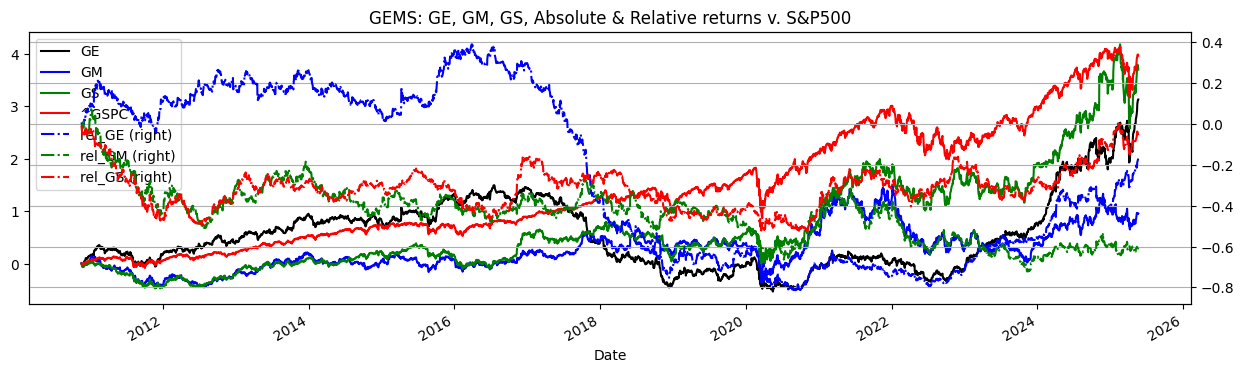

In [9]:
benchmark = ['^GSPC'] ; tickers_list = ['GE','GM','GS'] 
tickers = benchmark + tickers_list

gems = yf.download(tickers,start, end, interval = "1d",group_by = 'column',auto_adjust = True, prepost = True)['Close']
gems = gems.tz_localize(None).ffill().dropna(how='any',axis=0)
gems_rel = gems[tickers_list].div(gems[bm_ticker], axis=0).mul(gems.iloc[0,list(gems.columns).index(bm_ticker)])
gems_rel.columns = ['rel_' + i for i in tickers_list]
gems = round(pd.concat([gems,gems_rel],axis=1),2)
gems_returns = np.exp(np.log(gems/gems.shift()).cumsum()) - 1

gems_returns.plot(figsize=(15,4),grid=True,style = ['k','b','g','r','b-.','g-.','r-.'],
                    secondary_y = list(gems_rel.columns), title = 'GEMS: GE, GM, GS, Absolute & Relative returns v. S&P500')

### 7. Sector Average

We previously looked at the broad market number of bullish/bearish issues. Next, let’s drill down and look at what happens at the sector level.
We will concatenate one specific column from the df_SP500 dataframe with the historical regime df. We will calculate the sector average using a pivot table.

1. drop tickers without values
2. We rename the the columns 'ticker'
3. We concatenate one target column (sector, industry, sub-industry, etc) of df_SP500 with the transposed df_historical
4. We calculate the average of each sector score using pivot_table, then transpose
5. We calculate sector average for both the absolute and relative series
6. We concatenate witht he bullbear df adding the suffix "_abs" and "_rel"

In [10]:

def sector_avg_df(df_table, target_col, df_historical):
    """
    Calculate the average absolute bullish/bearish count for each sector.
    """
    df_historical = df_historical.copy().dropna(how='all', axis=1)    
    df_historical.columns.names = ['ticker']
    sector_df = pd.concat([df_table[[target_col]], df_historical.T], axis=1)
    sector_avg_df = pd.pivot_table(sector_df, values=list(df_historical.index), index=[target_col], aggfunc="mean").T
    return sector_avg_df

sector_avg_abs = round(sector_avg_df(df_SP500, 'sector', bo_abs).round(2),2)
sector_avg_rel = round(sector_avg_df(df_SP500, 'sector', bo_rel).round(2),2)
bullbear = pd.concat([bullbear, sector_avg_abs.add_suffix('_abs'), sector_avg_rel.add_suffix('_rel')], axis=1)

bullbear.tail()

,benchmark,bm_returns,bulls_absolute,bears_absolute,bulls_relative,bears_relative,bullbear_absolute_avg,bullbear_relative_avg,Communication Services_abs,Consumer Discretionary_abs,...,Consumer Discretionary_rel,Consumer Staples_rel,Energy_rel,Financials_rel,Health Care_rel,Industrials_rel,Information Technology_rel,Materials_rel,Real Estate_rel,Utilities_rel
2025-05-14 00:00:00,5893.0,3.59,54.69,45.31,48.1,51.9,0.09,-0.04,0.13,0.02,...,-0.1,-0.32,-0.3,0.59,-0.46,-0.06,-0.22,-0.44,-0.03,0.61
2025-05-15 00:00:00,5917.0,3.61,54.69,45.31,48.3,51.7,0.09,-0.03,0.13,0.02,...,-0.1,-0.32,-0.3,0.59,-0.46,-0.06,-0.22,-0.36,-0.03,0.61
2025-05-16 00:00:00,5958.0,3.64,54.69,45.31,48.3,51.7,0.09,-0.03,0.13,0.02,...,-0.1,-0.32,-0.3,0.59,-0.46,-0.06,-0.22,-0.36,-0.03,0.61
2025-05-19 00:00:00,5964.0,3.65,54.78,45.22,48.3,51.7,0.10,-0.03,0.13,0.02,...,-0.1,-0.32,-0.3,0.59,-0.46,-0.06,-0.22,-0.36,-0.03,0.61
2025-05-20 00:00:00,5940.0,3.63,54.98,45.02,48.3,51.7,0.10,-0.03,0.13,0.02,...,-0.1,-0.32,-0.3,0.59,-0.46,-0.06,-0.22,-0.36,-0.03,0.61


<Axes: title={'center': 'S&P500, sectors in relative'}>

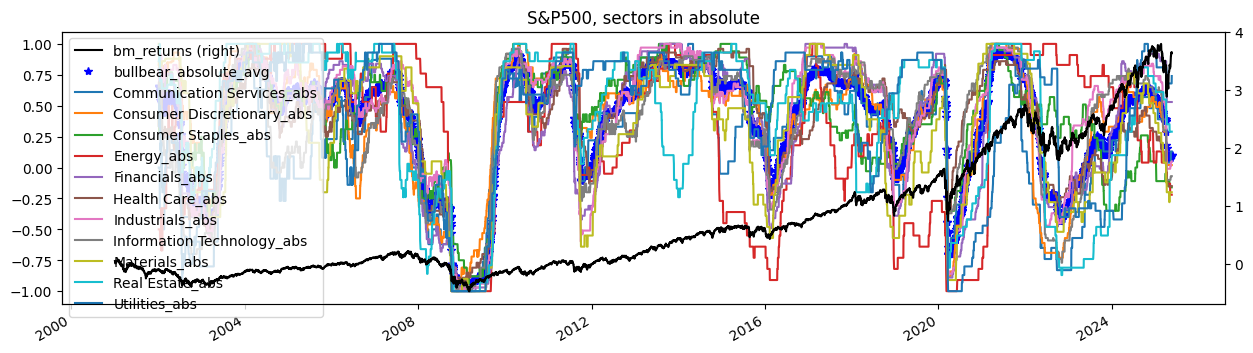

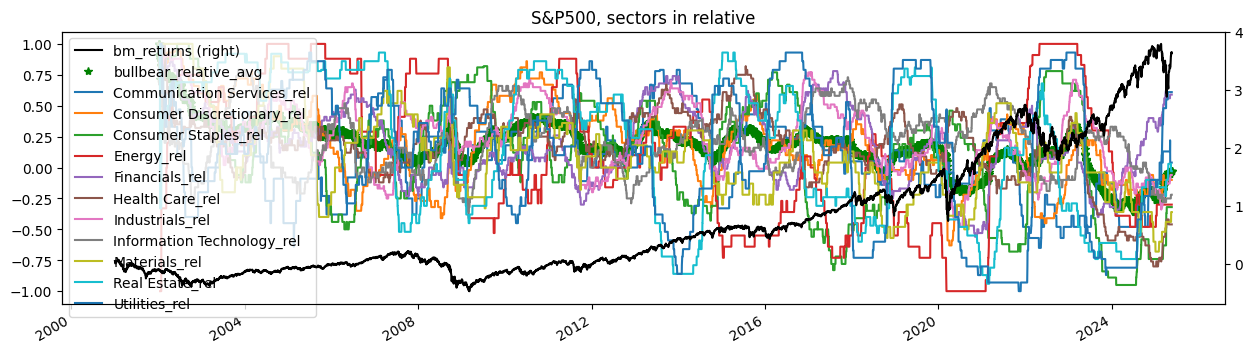

In [11]:
sectors = df_SP500['sector'].unique().tolist()
sector_avg_abs_cols = [i+'_abs' for i in sectors]
sector_avg_rel_cols = [i+'_rel' for i in sectors]

bullbear[['bm_returns', 'bullbear_absolute_avg']+sector_avg_abs_cols].plot(figsize= (15,4),secondary_y =['bm_returns'],style = ['k','b*'],
                                                                           title = 'S&P500, sectors in absolute')

bullbear[['bm_returns', 'bullbear_relative_avg']+sector_avg_rel_cols].plot(figsize= (15,4),secondary_y =['bm_returns'],style = ['k','g*'],
                                                                           title = 'S&P500, sectors in relative')


### 8. Cyclicals v. defensives

1. Define defensives and cyclicals lists
2. We calculate the average of those two sectors. These are equal weight averages. 
3. We plot the defensives and cyclicals


In [12]:
defensives_list = ['Consumer Staples_rel', 'Consumer Staples_abs','Utilities_rel', 'Utilities_abs']
bullbear['defensives_rel'] = bullbear[ ['Consumer Staples_rel','Utilities_rel']].mean(axis=1)
bullbear['defensives_abs'] = bullbear[['Consumer Staples_abs','Utilities_abs']].mean(axis=1)
defensives_plot =['benchmark'] + defensives_list +['defensives_rel','defensives_abs'] 
                   
cyclicals_list = ['Consumer Discretionary_rel', 'Consumer Discretionary_abs',
                   'Information Technology_rel', 'Information Technology_abs',]
bullbear['cyclicals_abs'] = bullbear[[ 'Consumer Discretionary_abs', 'Information Technology_abs']].mean(axis=1)          
bullbear['cyclicals_rel'] = bullbear[[ 'Consumer Discretionary_rel', 'Information Technology_rel']].mean(axis=1)
cyclicals_plot = ['benchmark'] + cyclicals_list + ['cyclicals_rel','cyclicals_abs']

bullbear['rotation_rel'] = bullbear['cyclicals_rel'].sub(bullbear['defensives_rel'], fill_value =0)                   
bullbear['rotation_abs'] = bullbear['cyclicals_abs'].sub(bullbear['defensives_abs'], fill_value =0)     

<Axes: title={'center': 'bm_returns, rotation_rel, rotation_abs'}>

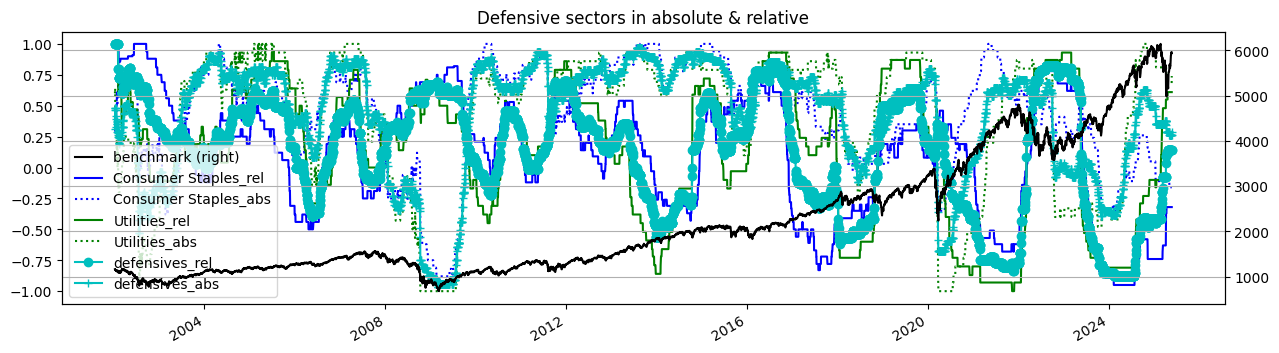

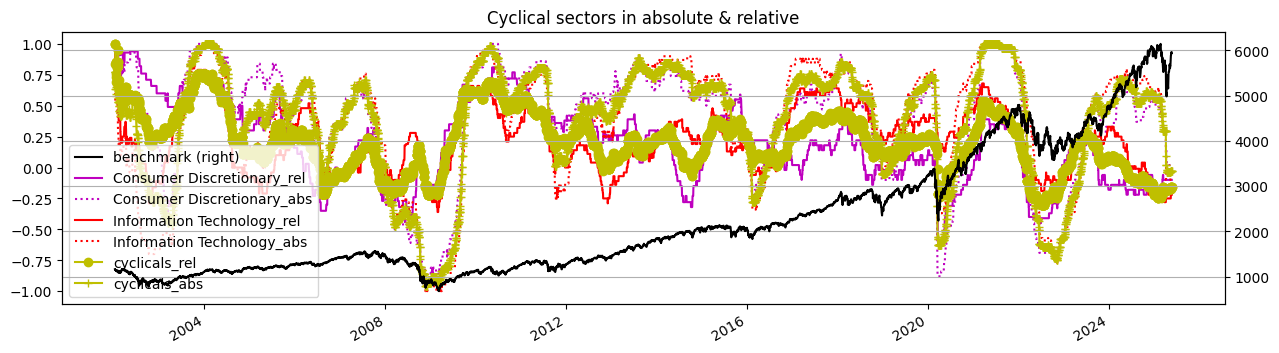

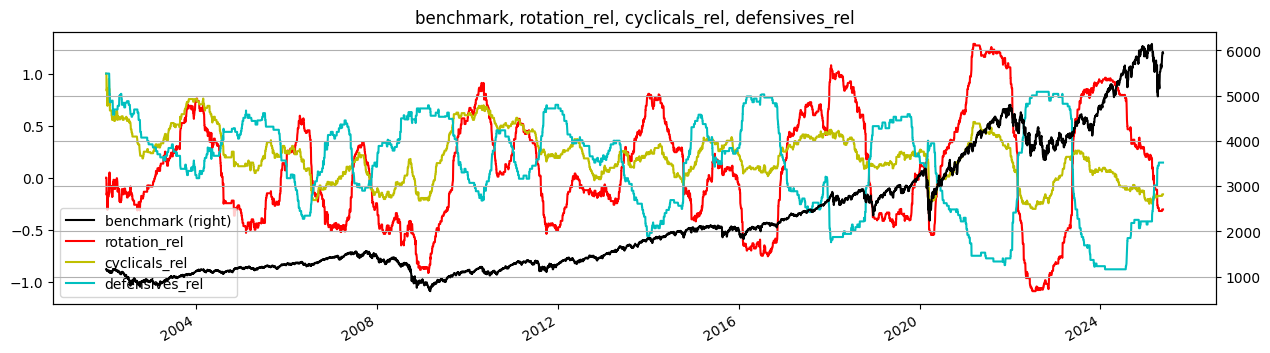

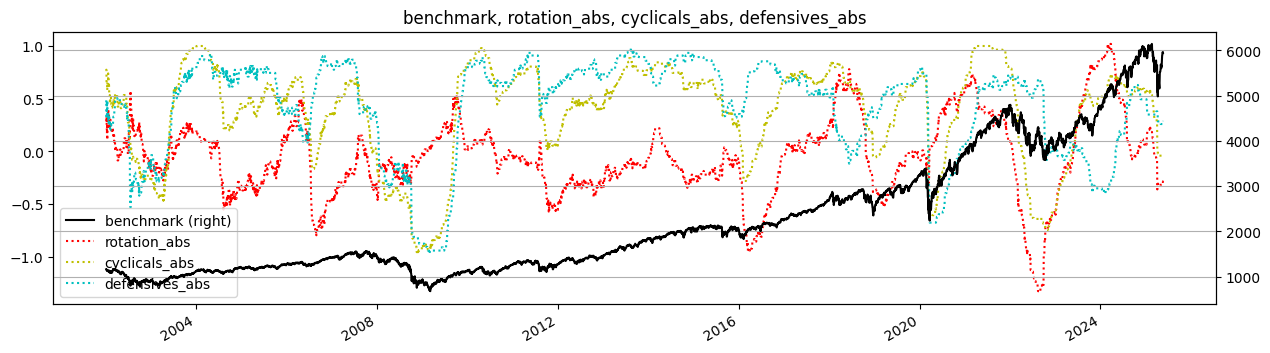

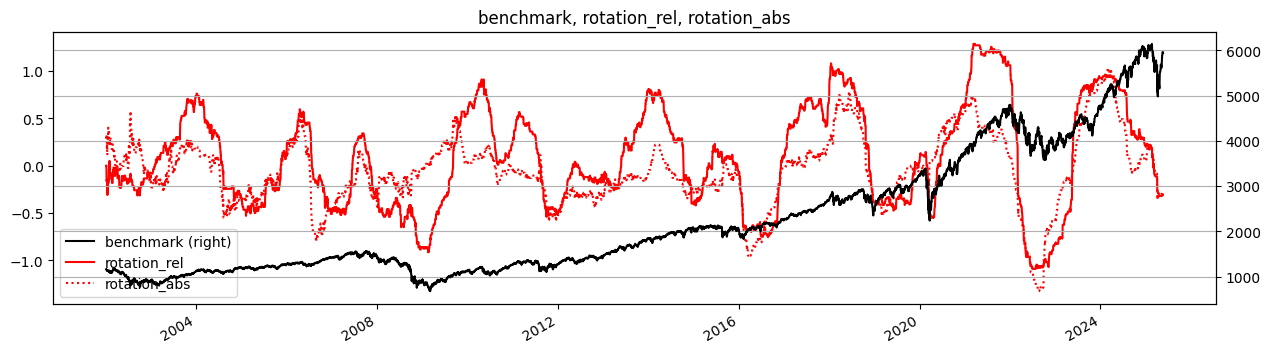

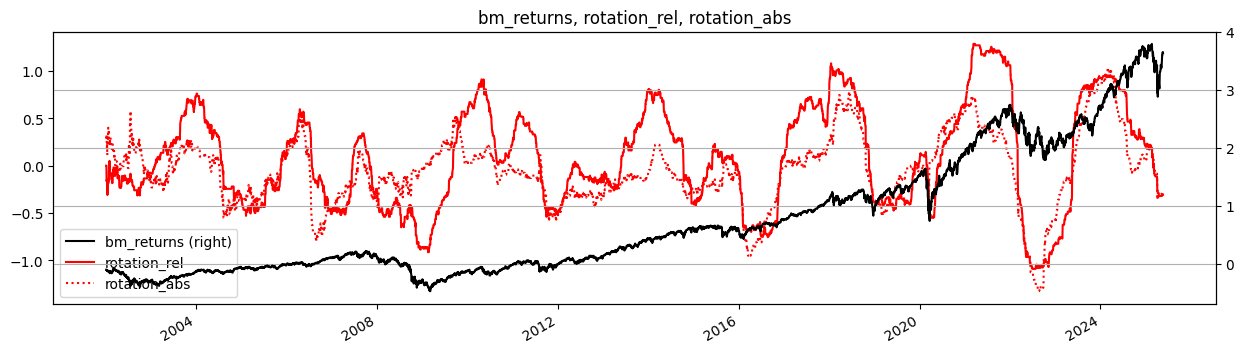

In [13]:
bullbear[window:][defensives_plot].plot(figsize=(15,4),grid=True,secondary_y=['benchmark'],
            style = ['k','b','b:','g','g:','co-','c+-'],title = 'Defensive sectors in absolute & relative')

bullbear[window:][cyclicals_plot].plot(figsize=(15,4),grid=True,secondary_y=['benchmark'],
            style = ['k','m','m:','r','r:','yo-','y+-'],title = 'Cyclical sectors in absolute & relative')

bullbear[window:][['benchmark', 'rotation_rel', 'cyclicals_rel','defensives_rel'
                   ]].plot(figsize=(15,4),grid=True,secondary_y=['benchmark'],
            style = ['k','r','y','c'], title = str('benchmark, rotation_rel, cyclicals_rel, defensives_rel') )
                   
bullbear[window:][['benchmark', 'rotation_abs', 'cyclicals_abs','defensives_abs'
                   ]].plot(figsize=(15,4),grid=True,secondary_y=['benchmark'],
            style = ['k','r:','y:','c:'],title = str('benchmark, rotation_abs, cyclicals_abs, defensives_abs') )  
                   
bullbear[window:][['benchmark', 'rotation_rel','rotation_abs']].plot(figsize=(15,4),grid=True,secondary_y=['benchmark'],
            style = ['k','r','r:'],title = str('benchmark, rotation_rel, rotation_abs') )     

bullbear[window:][['bm_returns', 'rotation_rel','rotation_abs']].plot(figsize=(15,4),grid=True,secondary_y=['bm_returns'],
            style = ['k','r','r:'],title = str('bm_returns, rotation_rel, rotation_abs') )     

### 9. Cross-market comparison

The relative method is particulary useful to compare stocks in the same sectors. This is a three step process:
1. Build the currency dictionary, download hsitorical data. 
2. Convert into benchmark currency
3. Calculate returns in benchmark currency for the absolute and relative series

Step1:
1. We build a dictionary fo tickers and their correpsponding currency
2. We generate a tickers list from the dictionary
3. We download historical prices in local currency
4. We add the benchmark prices from the bm_df we built earlier
5. We forward fill missing values for the entire df

In [14]:
fx_dict = {'7203.T': 'USDJPY','VOW3.DE' :'EURUSD', 'RNO.PA':'EURUSD','F':'local' ,'TSLA':'local' ,'GM':'local' ,'005380.KS':'USDKRW' }
tickers = list(fx_dict.keys()) ; bm = 'SP500' ; start = '2021-12-30'
px_df = pd.DataFrame()
px_df = yf.download(tickers,start, end, interval = "1d",
                    group_by = 'column',auto_adjust = True, prepost = True)['Close']
px_df[bm] = bm_df[start:][[bm]].copy()
px_df = round(px_df.tz_localize(None).ffill(),2)
px_df.tail(3)

[*********************100%***********************]  7 of 7 completed


Ticker,005380.KS,7203.T,F,GM,RNO.PA,TSLA,VOW3.DE,SP500
Date,,,,,,,,
2025-05-16,193800.0,2642.5,10.80,50.37,49.06,349.98,102.85,5958.38
2025-05-19,191000.0,2665.0,10.75,50.03,48.78,342.09,97.50,5963.60
2025-05-20,189500.0,2672.5,10.72,50.21,49.32,343.82,98.16,5940.46


1. We calculate daily log returns
2. We calculate cumulative returns using expanding().sum() instead of cumsum() to circumvent NaN
3. We calculate relative cumulative returns in local currency
4. We copy the local price df to instantiate the currency adjusted px_df_usd
5. We loop through the fx_dict to divide the px_df by the corresponding currency

<Axes: title={'center': 'Cumulative returns relative to S&P500 in LOCAL currency'}, xlabel='Date'>

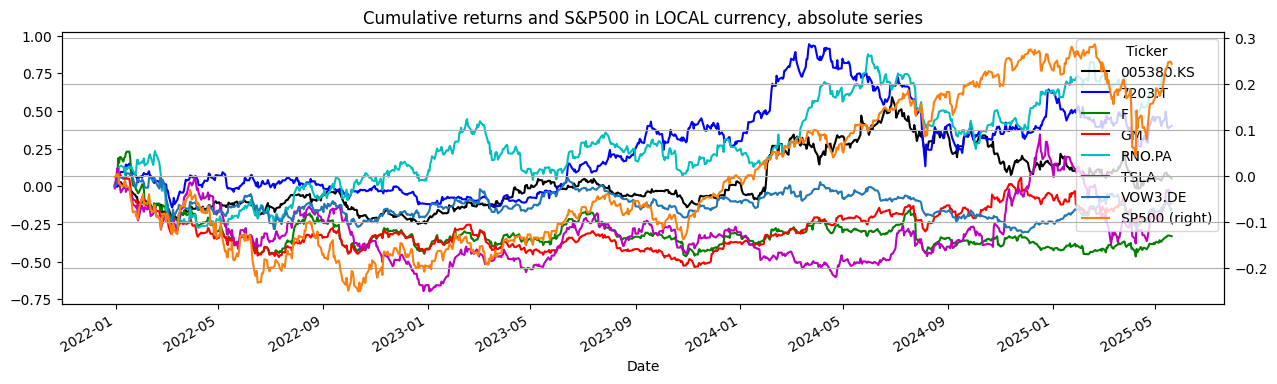

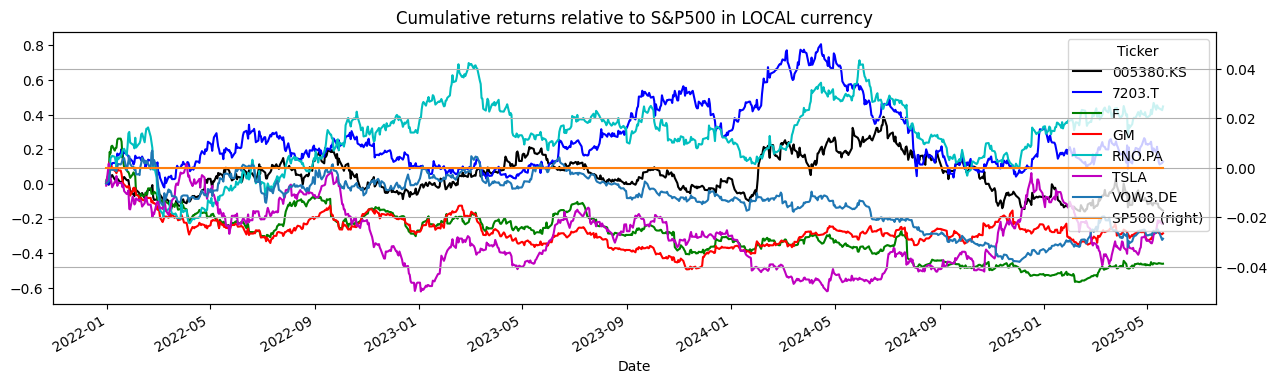

In [15]:
daily_log_returns_abs = np.log(px_df/px_df.shift())
cumul_returns_abs = daily_log_returns_abs.expanding().sum().apply(np.exp) - 1
daily_log_returns_rel = daily_log_returns_abs.sub(daily_log_returns_abs[bm], axis=0)
cumul_returns_rel = daily_log_returns_rel.expanding().sum().apply(np.exp) - 1

cumul_returns_abs.plot(figsize=(15,4),grid=True,secondary_y = [bm],style = ['k','b','g','r','c','m'],
                       title = 'Cumulative returns and S&P500 in LOCAL currency, absolute series')
cumul_returns_rel.plot(figsize=(15,4),grid=True,secondary_y = [bm],style = ['k','b','g','r','c','m'],
                       title = 'Cumulative returns relative to S&P500 in LOCAL currency')


1. Build a dictionary comprehension using px_df key divided by the corresponding currency value
2. Generate a df px_df_usd from the dictionary
3. Import benchmark
4. We localize timezone to align benchmark and px_df_usd, drop NaN and re-order columns

In [16]:

px_dict_usd = {key:px_df[key].div(ccy_df[value]).ffill() for key,value in fx_dict.items()}
px_df_usd = pd.DataFrame(px_dict_usd)
px_df_usd[bm] = bm_df[start:][[bm]].copy()
px_df_usd = round(px_df_usd.tz_localize(None).ffill(),2)
px_df_usd = px_df_usd.dropna(subset = fx_dict.keys())
px_df_usd = px_df_usd[px_df.columns]
px_df_usd.tail(2)

,005380.KS,7203.T,F,GM,RNO.PA,TSLA,VOW3.DE,SP500
Date,,,,,,,,
2025-05-19,136.61,18.34,10.75,50.03,43.6,342.09,87.15,5963.60
2025-05-20,136.07,18.51,10.72,50.21,43.7,343.82,86.98,5940.46


<Axes: title={'center': 'cumulative returns relative to S&P 500, in USD'}, xlabel='Date'>

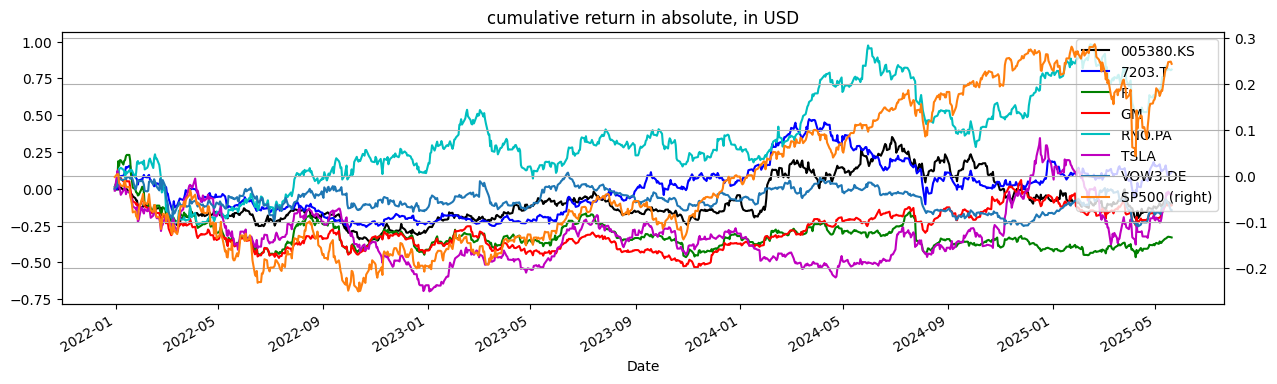

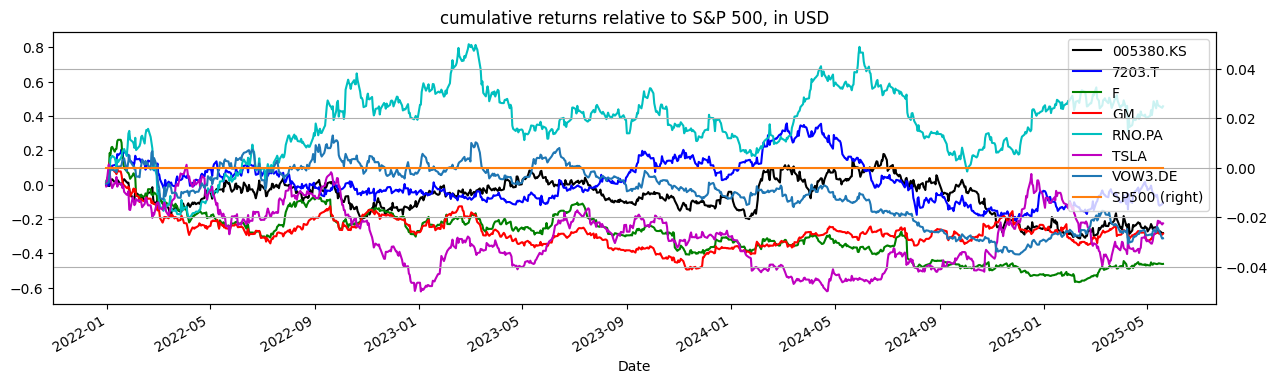

In [17]:
daily_log_returns_abs_usd = np.log(px_df_usd/px_df_usd.shift())
cumul_returns_abs_usd = daily_log_returns_abs_usd.expanding().sum().apply(np.exp) - 1
daily_log_returns_rel_usd = daily_log_returns_abs_usd.sub(daily_log_returns_abs_usd[bm], axis=0)
cumul_returns_rel_usd = round(daily_log_returns_rel_usd.expanding().sum().apply(np.exp) - 1,4)

cumul_returns_abs_usd.plot(figsize=(15,4),secondary_y = [bm],style = ['k','b','g','r','c','m'],
                       grid= True, title = 'cumulative return in absolute, in USD')

cumul_returns_rel_usd.plot(figsize=(15,4),secondary_y = [bm],style = ['k','b','g','r','c','m'],grid=True,
                                   title = 'cumulative returns relative to S&P 500, in USD')

Next, we build a heatmap of returns

def returns_table(daily_log_returns, range_days): We build a table of returns for a universe of securities over various time periods
1. We convert the index of daily_log_returns to time. Today's date is logically the last row
2. We use relativedelta from today's date to calculate the cumulative sum of the returns
3. We apply np.exp and subtract 1 to convert log returns into geometric returns
4. We calculate the range from a set period 

def heatmap(df, subset_cols, clrmap = 'RdYlGn', prec =1):    

In [18]:
def returns_table(daily_log_returns, range_days):
    daily_log_returns.index = pd.to_datetime(daily_log_returns.index)
    dt_today = daily_log_returns.index.max()

    rtrns_df = pd.DataFrame()
    rtrns_df['1D'] = daily_log_returns.ffill()[-1:].sum()
    rtrns_df['1W'] = daily_log_returns[dt_today + relativedelta(weeks = - 1):].sum()
    rtrns_df['1M'] = daily_log_returns[dt_today + relativedelta(months = - 1):].sum()
    rtrns_df['3M'] = daily_log_returns[dt_today + relativedelta(months = - 3):].sum()
    rtrns_df['6M'] = daily_log_returns[dt_today + relativedelta(months = - 6):].sum()
    rtrns_df['1Y'] = daily_log_returns[dt_today + relativedelta(years = -1):].sum()
    rtrns_df['2Y'] = daily_log_returns[dt_today + relativedelta(years = -2):].sum()
    rtrns_df['3Y'] = daily_log_returns[dt_today + relativedelta(years = -3):].sum()
    rtrns_df['Max'] = daily_log_returns.sum()
    rtrns_df = round((np.exp(rtrns_df)-1)*100,1)
    cumsum = daily_log_returns[dt_today + relativedelta(days = - range_days):].cumsum()
    rng = round((cumsum.tail(1) - cumsum.min()) / (cumsum.max() - cumsum.min()),2)
    rtrns_df = pd.concat([rtrns_df,rng.T],axis=1)
    rtrns_df =rtrns_df.rename(columns={rtrns_df.columns[-1]: f'range {range_days}d'})
    return rtrns_df

def heatmap(df, subset_cols, clrmap = 'RdYlGn', prec =1):    
    try:
        return df.style.background_gradient(subset= subset_cols,cmap= clrmap).format(precision = prec)
    except:
        return df.style.background_gradient(subset= subset_cols,cmap= clrmap).set_precision(prec)

returns_table_abs = returns_table(daily_log_returns_abs, range_days=364)
returns_table_rel_usd = returns_table(daily_log_returns_rel_usd, range_days=364)

In [19]:
sort_period = ['6M']
heatmap(returns_table_abs.sort_values(by=sort_period, ascending = False), 
        subset_cols = returns_table_abs.columns, clrmap = 'RdYlGn', prec =1)

,1D,1W,1M,3M,6M,1Y,2Y,3Y,Max,range 364d
Ticker,,,,,,,,,,
RNO.PA,1.1,3.0,17.8,1.0,24.4,7.0,60.1,124.5,79.9,0.9
VOW3.DE,0.7,-3.0,9.6,0.7,18.3,-11.9,-11.7,-1.6,-15.0,0.6
F,-0.3,1.6,13.0,16.4,1.6,-5.9,5.9,5.5,-33.0,0.5
SP500,-0.4,1.6,12.5,-3.3,0.4,12.0,41.7,52.3,24.3,0.8
7203.T,0.3,-2.9,5.1,-1.3,-0.4,-19.6,44.1,45.5,40.2,0.5
TSLA,0.5,8.0,42.4,-4.6,-0.6,93.7,90.9,45.4,-3.6,0.7
GM,0.4,1.2,12.7,5.3,-8.5,10.8,57.1,43.0,-11.2,0.6
005380.KS,-0.8,-3.2,1.2,-4.3,-9.4,-18.8,2.3,20.7,5.1,0.1


In [20]:
heatmap(returns_table_rel_usd.sort_values(by=sort_period, ascending = False), 
        subset_cols = returns_table_rel_usd.columns, clrmap = 'RdYlGn', prec =1)

,1D,1W,1M,3M,6M,1Y,2Y,3Y,Max,range 364d
RNO.PA,0.6,0.8,5.8,-3.3,16.4,-8.0,7.9,36.8,45.6,0.6
VOW3.DE,0.2,-5.0,-1.6,-3.6,10.6,-24.2,-40.5,-40.0,-31.2,0.3
7203.T,1.3,-3.5,-6.5,7.4,6.3,-22.8,-2.3,-15.4,-10.2,0.3
F,0.1,-0.0,0.5,20.4,1.2,-16.0,-25.2,-30.7,-46.1,0.4
SP500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan
TSLA,0.9,6.2,26.7,-1.4,-1.0,73.0,34.7,-4.5,-22.5,0.7
GM,0.8,-0.4,0.2,8.9,-8.8,-1.1,10.8,-6.1,-28.5,0.4
005380.KS,-0.0,-4.6,-5.8,2.3,-10.0,-29.9,-30.8,-27.4,-28.1,0.1


In [21]:
### Save df and read: NO need to publish in the book version
returns_table_abs.sort_values(by=sort_period, ascending = False).to_csv('returns_table_abs.csv')
returns_table_rel_usd.sort_values(by=sort_period, ascending = False).to_csv('returns_table_rel_usd.csv')

### 10. Disney MCU rise and fall



In [22]:
ticker = 'DIS' ; bm = 'SP500'; ccy = 'local' ;
df = yf.download(ticker,start = '2017-12-30', end = None ,interval = "1d",group_by = 'column',auto_adjust = True)
df = yf_droplevel(df,ticker)
start = '2019-12-30'; end= None
df1 = rel_fx(df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase = True, mult = 1)
df2 = rel_fx(df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase = False, mult = 2000)

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'DIS Absolute vs Relative series continuous'}, xlabel='Date'>

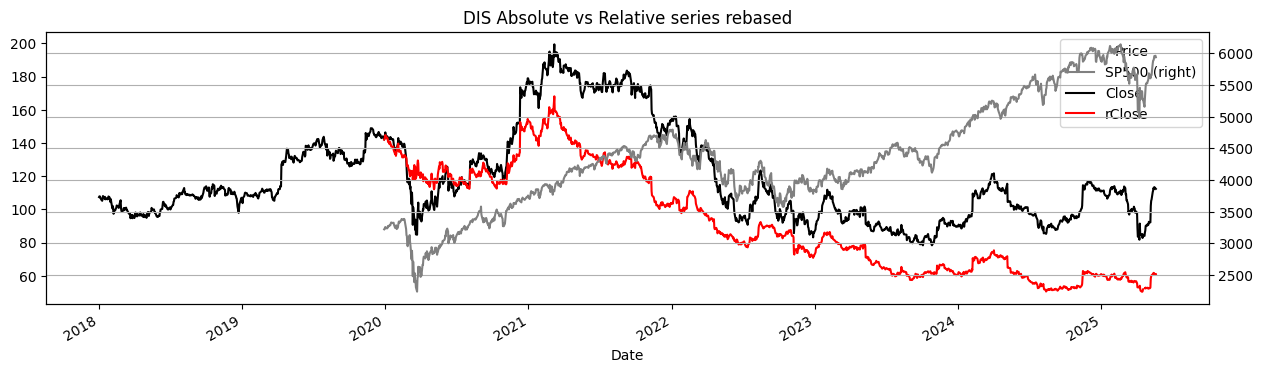

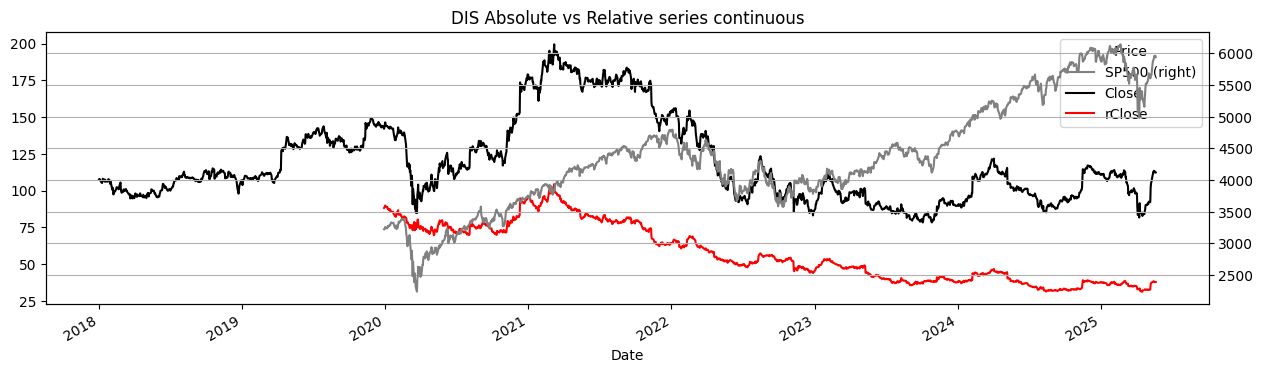

In [23]:
df1 = rel_fx(df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase = True, mult = 100)
df1[[bm,'Close','rClose']].plot(figsize=(15,4),grid=True, secondary_y = [bm], 
                                style = ['grey','k', 'r' ],title= f'{ticker} Absolute vs Relative series rebased')

df2 = rel_fx(df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase = False, mult = 2000)
df2[[bm,'Close','rClose']].plot(figsize=(15,4),grid=True, secondary_y = [bm], 
                                style = ['grey','k', 'r' ],title= f'{ticker} Absolute vs Relative series continuous')